In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.special as special
import scipy.stats as spstats

# Primer on 2-D Gaussian Distributions

We start with the full 2-dimensional Gaussian PDF (lifted from wikipedia):

$$f(x,y) = \frac{1}{2 \pi \sigma_X \sigma_Y \sqrt{1-\rho^2}} e^{-\frac{1}{2(1-\rho^2)} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{\sigma_Y})^2 - 2 \rho (\frac{x - \mu_X}{\sigma_X}) (\frac{y - \mu_Y}{\sigma_Y}) \right]}$$

For our purposes, we're only really concerned with ellipses, and the orientation of the ellipse doesn't particularly matter for now, so let's set $\rho = 0$ and define $\sigma_Y = 1$, while we adjust the means $\mu_X, \mu_Y$ later accordingly. We then get the much simpler:

$$f(x,y) = \frac{1}{2 \pi \sigma_X} e^{-\frac{1}{2} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{1})^2 \right] }$$

We now just need to adjust $\sigma_X$ to be our relative stretch of the ellipse.

Let's start with the zero-mean example of a circular distribution i.e. $\sigma_X = 1, \mu_X = \mu_Y = 0$:

$$f(x,y) = \frac{1}{2 \pi} e^{-\frac{1}{2} \left[ x^2 + y^2 \right]} $$

There's no indefinite integral for Gaussians, so we can only use the error function given by

$$ erf(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt $$

which is the probability of obtaining a random variable in the range $[-x,x]$ for a zero-mean standard deviation of (**IMPORTANT**) $\frac{1}{\sqrt{2}}$. Explicitly, we convert the distribution via

$$\begin{align}
f(x,y) &= \frac{1}{2 \pi} e^{-\frac{1}{2} \left[ x^2 + y^2 \right]} \\
&= \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} x^2} \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} y^2} \\
\end{align}
$$

The two terms are independent and can be integrated separately (and are identical anyway) so we just integrate over the desired limits $-a, a$ by defining our dummy variable $t = \frac{x}{\sqrt{2}}, dx = \sqrt{2} dt$ like so:

$$\begin{align}
\frac{1}{\sqrt{2\pi}} \int_{-a}^{a}  e^{-\frac{1}{2} x^2} &= \frac{2}{\sqrt{2 \pi}} \int_{0}^{a} e^{-\frac{1}{2} x^2} dx\\
&= \frac{2}{\sqrt{\pi}} \int_{0}^{a/\sqrt{2}} e^{-t^2} dt\\
&= erf\left(a/\sqrt{2}\right)
\end{align}
$$

This form results in the standard 68, 95, 99.7 rule as demonstrated here:

In [3]:
print(special.erf(1/np.sqrt(2)))
print(special.erf(2/np.sqrt(2)))
print(special.erf(3/np.sqrt(2)))

0.6826894921370859
0.9544997361036416
0.9973002039367398


But more importantly, for 2-D and above the product of the two $erf$ functions must be taken into account, which results in the equivalent of the $1,2,3 \sigma$ rule becoming:

In [4]:
print(special.erf(1/np.sqrt(2))**2)
print(special.erf(2/np.sqrt(2))**2)
print(special.erf(3/np.sqrt(2))**2)

0.4660649426743922
0.9110697462219214
0.9946076967722628


But wait! What we did here is an integral over a **SQUARE** with limits $[-a,a], [-a,a]$. What we're most likely concerned with is a smooth circular integral that stretches $c = 1 \sigma$ in all directions (in the circular case), as this would *respect* the evolution of the probability distribution. To do this we simply integrate using the conditional limits by defining the **POLAR** limits and integrating via polar coordinates like so, $r^2 = x^2 + y^2$:

$$ \begin{align}
\frac{1}{2\pi} \int_{0}^{2\pi} \int_{0}^{c} e^{-\frac{1}{2} r^2} r dr d\theta &= \frac{1}{2\pi}  \int_{0}^{2\pi} \left[ \int_{0}^{c} r e^{-\frac{1}{2} r^2}  dr \right] d\theta \\
&= \frac{1}{2\pi}  \int_{0}^{2\pi} \left[ \left(1 -e^{ -\frac{1}{2} c^2} \right) \right] d\theta \\
&= 1 -e^{ -\frac{1}{2} c^2}
\end{align}
$$

The equivalent of the $1,2,3 \sigma$ rule is then:

In [5]:
def circularProbability(c):
    return (1-np.exp(-0.5*c**2))

print(circularProbability(1))
print(circularProbability(2))
print(circularProbability(3))

0.3934693402873666
0.8646647167633873
0.9888910034617577


We can verify this via simulation, counting everything within multiple sigmas..

0.39376
0.86257
0.98901


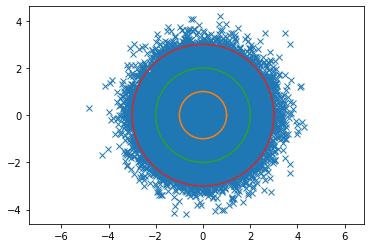

In [6]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 100000).T

theta = np.arange(0,2*np.pi+0.001/2,0.001)
circx = np.cos(theta)
circy = np.sin(theta)

plt.figure()
plt.plot(x, y, 'x')
plt.plot(circx,circy)
plt.plot(2*circx,2*circy)
plt.plot(3*circx,3*circy)
plt.axis('equal')

xy = np.vstack((x,y)).T
xynorm = np.linalg.norm(xy, axis=1)
print(len(np.argwhere(xynorm <= 1)) / len(xynorm))
print(len(np.argwhere(xynorm <= 2)) / len(xynorm))
print(len(np.argwhere(xynorm <= 3)) / len(xynorm))

The most straightforward way to extend from circular to elliptical distributions and see that the same rules hold - that is, that drawing an ellipse which matches the $n \sigma$ on both the major and minor axes will also result in the same percentages - is to simply construct a linear transform matrix which shapes the ellipse back to the circle. It shouldn't be too hard to see heuristically that the linear transforms preserve the percentages, but explicitly, we may consider the general 2-D Gaussian distribution (un-correlated i.e. $\rho = 0$):

$$
f(x,y) = \frac{1}{2 \pi \sigma_X \sigma_Y} e^{-\frac{1}{2} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{\sigma_Y})^2 \right] }
$$

Correlated distributions (i.e. ellipses not aligned to the x-axis or y-axis) may be simply rotated in the plane to this form, so we will focus on this. Then, for arbitrary $\sigma_X, \sigma_Y$, we may use these to appropriately parametrize $x, y$ in the following manner:

$$
x = \sigma_X r \cos \theta \\
y = \sigma_Y r \sin \theta
$$

Integrating the distribution over the ellipse for $1 \sigma$ in both directions appropriately results in the Jacobian 

$$
\sigma_X \sigma_Y r dr d\theta
$$

instead of the unit-circle case of 

$$
r dr d\theta
$$

It is clear that the integrand when compared to the unit-circle case has now transformed like so:

$$
\frac{1}{2 \pi} e^{-\frac{1}{2} \left[x^2 + y^2 \right]} (r) = \frac{1}{2 \pi} e^{-\frac{1}{2} r^2} (r) \rightarrow \frac{1}{2 \pi \sigma_X \sigma_Y} e^{-\frac{1}{2} r^2} (\sigma_X \sigma_Y r) = \frac{1}{2 \pi \sigma_X \sigma_Y} e^{-\frac{1}{2} \left[ (\frac{x - \mu_X}{\sigma_X})^2 + \frac{y - \mu_Y}{\sigma_Y})^2 \right]} (\sigma_X \sigma_Y r)
$$

The limits have not changed, since we edited the Jacobian to account for our transformation of the differential area; hence since the extra coefficients of $\sigma_X \sigma_Y$ cancel out the $\frac{1}{\sigma_X \sigma_Y}$ of the denominator, we are left with the original integral

$$
\text{Integral over 1 sigma of ellipse} = \frac{1}{2 \pi \sigma_X \sigma_Y} \int_0^{2\pi} \int_0^1  e^{-\frac{1}{2} r^2} (\sigma_X \sigma_Y r) dr d\theta = \frac{1}{2 \pi} \int_0^{2\pi} \int_0^1 e^{-\frac{1}{2} r^2} r dr d\theta = \text{Integral over 1 sigma of unit circle}
$$

As usual, we can easily verify this via simulations:

0.39132
0.86401
0.98907


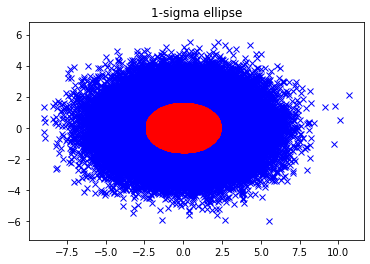

In [39]:
# Assumes each x,y pair in each row
def pointsInUncorrelatedZeroMeanEllipse(points, axx, axy):
    norms = np.linalg.norm(points, axis=1) # find the norm for each point from origin

    theta = np.arctan2(points[:,1]*axx, points[:,0]*axy) # find the equivalent theta for the ellipse projection for each point
    ellipseX = axx * np.cos(theta) # find the ellipse projection for each point with the same angle
    ellipseY = axy * np.sin(theta)
    ellipse = np.vstack((ellipseX, ellipseY)).T
    ellipseNorms = np.linalg.norm(ellipse, axis=1)
    
    isInEllipseIdx = np.argwhere(norms < ellipseNorms)
    
    return ellipse, isInEllipseIdx

mean = [0, 0]
cov = [[5, 0], [0, 2]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 100000).T
points = np.vstack((x,y)).T

# find the number of points in 1 sigma
ellipse, isInEllipseIdx = pointsInUncorrelatedZeroMeanEllipse(points, np.sqrt(cov[0][0]), np.sqrt(cov[1][1])) 

plt.figure()
plt.plot(x[:], y[:], 'bx')
plt.plot(ellipse[:,0], ellipse[:,1], 'k.')
plt.plot(points[isInEllipseIdx,0], points[isInEllipseIdx,1], 'ro')
plt.axis('equal')
plt.title("1-sigma ellipse")

print(len(isInEllipseIdx) / len(points))

# find the number of points in 2 or 3 sigma
ellipse, isInEllipseIdx = pointsInUncorrelatedZeroMeanEllipse(points, 2*np.sqrt(cov[0][0]), 2*np.sqrt(cov[1][1])) 
print(len(isInEllipseIdx) / len(points))
ellipse, isInEllipseIdx = pointsInUncorrelatedZeroMeanEllipse(points, 3*np.sqrt(cov[0][0]), 3*np.sqrt(cov[1][1])) 
print(len(isInEllipseIdx) / len(points))

# Combining Elliptical Errors (for Localization)

You have $N$ localization measurements with index $i=0,1,...,N-1$: each has its own error ellipse (i.e. covariance matrix $\Sigma_i$) and measurement mean $\mu_i$ which denotes the point. The error ellipses may not be equal nor aligned i.e. they can be rotated in any 'direction' and their semi-major/minor axes may all be different. This would reflect the typical scenario where there are different measurements (perhaps from different times, different sensors or any combination thereof) which have different *uncertainties*, of which the individual i'th measurement's uncertainty has been **estimated** and thence assigned to the values of the covariance matrix (the fact that it is estimated will become important soon).

The problem is usually this: find the best average of all the measurements, along with an 'averaged' ellipse to reflect the *standard error of the mean*. The former is usually straightforward, so we start with that.

## Precision-weighted mean

With differing measurement uncertainties, the only respectable way to combine the measurements would be to weight them via their precision; that is, the weighted average is given by

$$
\bar{\mu} = \frac{\sum_{i=0}^{N-1} \Sigma_i^{-1} \mu_i} {\sum_{i=0}^{N-1} \Sigma_i^{-1}}
$$

This is also known as the *inverse-variance weighted mean/average*. Each measurement is weighted by the inverse variance, favouring the *certain* measurements over the *uncertain* measurements. In the case that all the variances are equal this reverts to the simple mean

$$
\bar{\mu} = \frac{\sum_{i=0}^{N-1} \mu_i} {N}
$$

Nothing to dispute here, and no confusion; what is usually the issue is defining the final combined ellipse or what the standard error of this mean should be.

## Weighted Standard Error Of The Mean

The first method  of computing the standard error is to simply combine the individual variances $\Sigma_i$. 